# ML for churn rate predictions in Telecom company
## Author: Pablo Benayas
1. This is a ML assignment from my master: 'Master’s Degree in Big Data & Data Science. Applications for Commerce, Business and Finance'. Data has been modified to ensure company's anonymity.
2. Objective: Company XYZ wants me to predict which clients will not continue demanding their services in next month. To do so, they have provided me with several datasets that I will merge. Then, the target variable has to be inferred with the given data
3. Guidelines:
    1. Merge datasets, set a target variable and pre-process data.
    2. Run a quick model and check its performance
    3. Feature selection & Feature engineering to improve performance
    4. Run more models and select the best candidate
2. Let's begin

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import seaborn as sns
import matplotlib.pyplot  as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model.logistic import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import naive_bayes
from datetime import datetime


from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, precision_score, recall_score, roc_curve
import matplotlib.pyplot  as plt

C:\Users\pablo\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.linear_model.logistic module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)


### Explain datasets given:
1. Same datasets' names and variables for both December and January (but different values!):
    1. Clients (clientes). Variables:
        1. Age (edad), 
        2. Monthly subscription fee (financiacion), 
        3. Date customer signed up for the service (antiguedad), 
        4. Province (provincia), 
        5. Hired mobile lines (num_lineas), 
        6. Defaulted mobile lines (num_dt), 
        7. Incidences (incidencia)
    
    2. Products (productos). Variables:
        1. Type of internet connection (conexion), 
        2. Connection speed (vel_conexion), 
        3. Type of TV package hired (TV)
    
    3. Consumption (consumos). Variables: 
        1. Number of incoming calls (num_llamad_ent)
        2. Number of outgoing calls (num_llamad_sal) 
        3. Data consumption in MB (mb_datos)
        4. Seconds spent on incoming calls (seg_llamad_ent)
        5. Seconds spent on outgoing calls (seg_llamad_sal).
    
    4. Funding (financiacion). Variables:
        1. Funding (financiacion): binary variable
        2. Monthly amount paid for funded terminals (imp_financ)
        3. Discounts (Descuentos): binary variable
    


In [2]:
clientes_diciembre=pd.read_csv('clientes_diciembre.csv', sep='|')
consumos_diciembre=pd.read_csv('consumos_diciembre.csv', sep='|')
financiacion_diciembre=pd.read_csv('financiacion_diciembre.csv', sep='|')
productos_diciembre=pd.read_csv('productos_diciembre.csv', sep='|') 

df=clientes_diciembre.merge(consumos_diciembre,on='id', how='left')
df=df.merge(financiacion_diciembre,on='id', how='left')
data_diciembre=df.merge(productos_diciembre,on='id', how='left') 


clientes_enero=pd.read_csv('clientes_enero.csv', sep='|')
consumos_enero=pd.read_csv('consumos_enero.csv', sep='|')
financiacion_enero=pd.read_csv('financiacion_enero.csv', sep='|')
productos_enero=pd.read_csv('productos_enero.csv', sep='|')

df=clientes_enero.merge(consumos_enero,on='id', how='left')
df=df.merge(financiacion_enero,on='id', how='left')
data_enero=df.merge(productos_enero,on='id', how='left') 

# Let's define our target variable:
This is the idea:
If Customer Id is contained in both December and January datasets, then it is confirmed that that customer continues using company's services. 


The remaining customers Ids of December will, thus, represent the total number of clients that have stopped doing business with the entity. This is because they no longer appear in January.

In [3]:
data_diciembre['¿Abandona?']=data_diciembre.id.isin(data_enero.id).apply(lambda x: 0 if x else 1) 
data_diciembre.isnull().sum() 

id                    0
edad                  0
facturacion           0
antiguedad            0
provincia             0
num_lineas            0
num_dt            88950
incidencia        90235
num_llamad_ent        0
num_llamad_sal        0
mb_datos              0
seg_llamad_ent        0
seg_llamad_sal        0
financiacion      89095
imp_financ        89095
descuentos        76313
conexion              0
vel_conexion          0
TV                    0
¿Abandona?            0
dtype: int64

In [4]:
data_diciembre.to_csv('full_diciembre.csv') 

# There too many NAs in some variables. I will remove them from the dataset and create a new variable called 'number of NAs'

In [5]:
data_diciembre['number of NAs']=data_diciembre.apply(lambda x: x.isnull().sum(), axis=1) 

In [6]:
data_diciembre.drop(['num_dt','incidencia','financiacion','imp_financ',
                     'descuentos','id'], axis=1, inplace=True)
data_diciembre.isnull().sum() 

edad              0
facturacion       0
antiguedad        0
provincia         0
num_lineas        0
num_llamad_ent    0
num_llamad_sal    0
mb_datos          0
seg_llamad_ent    0
seg_llamad_sal    0
conexion          0
vel_conexion      0
TV                0
¿Abandona?        0
number of NAs     0
dtype: int64

In [7]:
data_diciembre.dtypes

edad                int64
facturacion       float64
antiguedad         object
provincia          object
num_lineas          int64
num_llamad_ent      int64
num_llamad_sal      int64
mb_datos            int64
seg_llamad_ent      int64
seg_llamad_sal      int64
conexion           object
vel_conexion       object
TV                 object
¿Abandona?          int64
number of NAs       int64
dtype: object

# Dates

In [8]:
data_diciembre['antiguedad'] = data_diciembre.antiguedad.apply(lambda x: datetime.timestamp(datetime.strptime(x, '%m/%d/%Y %I:%M %p'))) 

# Dealing with categorical variables

In [9]:
pd.DataFrame(data_diciembre.columns, index=data_diciembre.columns).apply(lambda x: len(data_diciembre[x[0]].unique()), axis=1)

edad                 68
facturacion       95467
antiguedad        95171
provincia            50
num_lineas            5
num_llamad_ent      251
num_llamad_sal      101
mb_datos          24456
seg_llamad_ent    19834
seg_llamad_sal    19828
conexion              2
vel_conexion         11
TV                    3
¿Abandona?            2
number of NAs         6
dtype: int64

variables with few unique values are likely to be categorical

In [10]:
data_diciembre.dtypes

edad                int64
facturacion       float64
antiguedad        float64
provincia          object
num_lineas          int64
num_llamad_ent      int64
num_llamad_sal      int64
mb_datos            int64
seg_llamad_ent      int64
seg_llamad_sal      int64
conexion           object
vel_conexion       object
TV                 object
¿Abandona?          int64
number of NAs       int64
dtype: object

In [11]:
# LabelEncoder() & dummies
dictLabelEncoder={}
dummies={}
categVars=data_diciembre.loc[:,['num_lineas','TV']]

transform1 = LabelEncoder()
for col in categVars:
    #labelEncoder
    transform1.fit_transform(list(data_diciembre[col].unique()))
        # I need to store LabelEncoder() in a variable, otherwise the fitting is not saved.
        
    dictLabelEncoder[col]=transform1.transform(data_diciembre[col])
    
    #dummies
    value_names_for_dummies=list(categVars[str(col)].unique())
    for i in  range(len(value_names_for_dummies)):
        dummies[str(col)+'_'+str(value_names_for_dummies[i])]=pd.get_dummies(categVars[str(col)]).iloc[:,i]         

data_diciembre.loc[:,['num_lineas','TV']]=pd.DataFrame(dictLabelEncoder)
dummies=pd.DataFrame(dummies)

data_diciembre=pd.concat([data_diciembre, dummies.reindex(data_diciembre.index)], axis=1) 

In [12]:
# I am not going to create dummies from these two variables
transform1.fit_transform(list(data_diciembre['provincia'].unique()))
data_diciembre['provincia']=transform1.transform(data_diciembre['provincia']) 

In [13]:
transform1.fit_transform(list(data_diciembre['conexion'].unique()))
data_diciembre['conexion']=transform1.transform(data_diciembre['conexion']) 

# Removing 'MB' characters in 'vel_conexion' variable

In [14]:
data_diciembre['vel_conexion']=data_diciembre.vel_conexion.apply(lambda x: float(x[:-2])) 

# Last check

In [15]:
data_diciembre.dtypes

edad                int64
facturacion       float64
antiguedad        float64
provincia           int32
num_lineas          int64
num_llamad_ent      int64
num_llamad_sal      int64
mb_datos            int64
seg_llamad_ent      int64
seg_llamad_sal      int64
conexion            int32
vel_conexion      float64
TV                  int32
¿Abandona?          int64
number of NAs       int64
num_lineas_5        uint8
num_lineas_3        uint8
num_lineas_4        uint8
num_lineas_2        uint8
num_lineas_1        uint8
TV_tv-futbol        uint8
TV_tv-familiar      uint8
TV_tv-total         uint8
dtype: object

In [16]:
data_diciembre.isnull().sum() 

edad              0
facturacion       0
antiguedad        0
provincia         0
num_lineas        0
num_llamad_ent    0
num_llamad_sal    0
mb_datos          0
seg_llamad_ent    0
seg_llamad_sal    0
conexion          0
vel_conexion      0
TV                0
¿Abandona?        0
number of NAs     0
num_lineas_5      0
num_lineas_3      0
num_lineas_4      0
num_lineas_2      0
num_lineas_1      0
TV_tv-futbol      0
TV_tv-familiar    0
TV_tv-total       0
dtype: int64

In [17]:
data_diciembre.describe()

,edad,facturacion,antiguedad,provincia,num_lineas,num_llamad_ent,num_llamad_sal,mb_datos,seg_llamad_ent,seg_llamad_sal,...,¿Abandona?,number of NAs,num_lineas_5,num_lineas_3,num_lineas_4,num_lineas_2,num_lineas_1,TV_tv-futbol,TV_tv-familiar,TV_tv-total
count,95467.000000,95467.000000,9.546700e+04,95467.000000,95467.000000,95467.000000,95467.000000,95467.000000,95467.000000,95467.000000,...,95467.000000,95467.000000,95467.000000,95467.000000,95467.000000,95467.000000,95467.000000,95467.000000,95467.000000,95467.000000
mean,51.462086,207.392912,1.182640e+09,24.524328,2.558518,124.815633,50.022762,12489.795898,9984.406612,10029.761342,...,0.074214,4.542805,0.029874,0.138121,0.314381,0.278861,0.238763,0.353714,0.497921,0.148365
std,19.590846,111.343491,2.272685e+08,14.453017,1.086095,72.492338,29.119904,7239.421267,5763.182070,5763.518604,...,0.262120,0.724093,0.170241,0.345029,0.464271,0.448441,0.426330,0.478124,0.499998,0.355464
min,18.000000,15.000439,7.889702e+08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,35.000000,111.383822,9.858640e+08,12.000000,2.000000,62.000000,25.000000,6177.500000,5006.000000,5055.000000,...,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,51.000000,206.808431,1.181438e+09,25.000000,3.000000,124.000000,50.000000,12466.000000,9965.000000,10024.000000,...,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,68.000000,304.436599,1.378266e+09,37.000000,3.000000,188.000000,75.000000,18785.500000,14969.000000,15007.000000,...,0.000000,5.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000
max,85.000000,399.998433,1.577759e+09,49.000000,4.000000,250.000000,100.000000,25000.000000,20000.000000,20000.000000,...,1.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [18]:
# First model

In [19]:
restOfVars=data_diciembre.loc[:, list(pd.DataFrame(data_diciembre.columns).apply(lambda x: x[0] not in ['TV_tv-total', 'num_lineas_5','¿Abandona?'], axis=1))]  
target=data_diciembre['¿Abandona?']
data_diciembre=pd.concat([restOfVars, target.reindex(target.index)], axis=1) 
print(data_diciembre.columns)
X, y = data_diciembre.iloc[:,:-1], data_diciembre.iloc[:,-1] 

scaler = MinMaxScaler()    
X=scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y) 

Index(['edad', 'facturacion', 'antiguedad', 'provincia', 'num_lineas',
       'num_llamad_ent', 'num_llamad_sal', 'mb_datos', 'seg_llamad_ent',
       'seg_llamad_sal', 'conexion', 'vel_conexion', 'TV', 'number of NAs',
       'num_lineas_3', 'num_lineas_4', 'num_lineas_2', 'num_lineas_1',
       'TV_tv-futbol', 'TV_tv-familiar', '¿Abandona?'],
      dtype='object')


In [20]:
classifier = LogisticRegression().fit(X_train, y_train)
y_pred     = classifier.predict(X_test) 

In [21]:
## métricas

def get_metrics(y1, y2): #y_real (y_test) and y_pred
    print('matriz de confusión')
    print(confusion_matrix(y1, y2))
    print('accuracy')
    print(accuracy_score(y1, y2))
    print('precision')
    print(precision_score(y1, y2))
    print('recall')
    print(recall_score(y1, y2))
    print('f1')
    print(f1_score(y1, y2))
    false_positive_rate, recall, thresholds = roc_curve(y1, y2)
    roc_auc = auc(false_positive_rate, recall)
    print('AUC')
    print(roc_auc)
    plt.plot(false_positive_rate, recall, 'b')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.title('AUC = %0.2f' % roc_auc)
    

matriz de confusión
[[22056    40]
 [ 1771     0]]
accuracy
0.9241211714920182
precision
0.0
recall
0.0
f1
0.0
AUC
0.4990948587979725


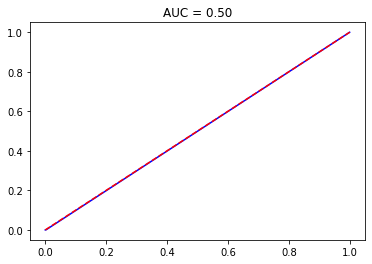

In [22]:
get_metrics(y_test, y_pred)  

# I have a obtained bad score in terms of precision and recall. Let's do some feature engineering and add more variables

In [23]:
corr = abs(data_diciembre.corr())
corr[['¿Abandona?']].sort_values(by = '¿Abandona?',ascending = False).style.background_gradient() 

,¿Abandona?
¿Abandona?,1
number of NAs,0.223008
provincia,0.00630453
num_llamad_ent,0.00612962
antiguedad,0.00314576
num_llamad_sal,0.00314091
TV_tv-familiar,0.00293872
edad,0.00286418
facturacion,0.00284625
TV,0.00264543


In [24]:
def proporciones_final (var,target,df):

    proporcion = pd.DataFrame()

    proporcion['%depositos'] = df[target].groupby(df[var]).mean()*100 
    proporcion['Conteo'] = df[target].groupby(df[var]).count() 
    proporcion= proporcion.round(3)   
    proporcion_filtered = proporcion[(proporcion['%depositos']>0) & (proporcion['Conteo']>10)]
        
    if len(proporcion_filtered)<100 and len(proporcion_filtered)>1:
        fig = plt.figure()
        ax = proporcion_filtered['Conteo'].plot(kind='bar',grid=True)
                
        ax2 = ax.twinx()
        ax2.plot(proporcion_filtered['%depositos'].values, linestyle='-', linewidth=2.0,color='g')
        plt.tight_layout()        
    
    else:        
        proporcion_filtered.reset_index(inplace=True)
        sns.lmplot(x = var,y ='%depositos',data=proporcion_filtered, fit_reg=True,ci=None) 

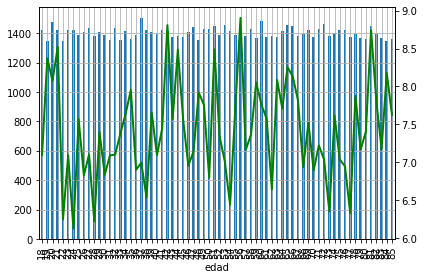

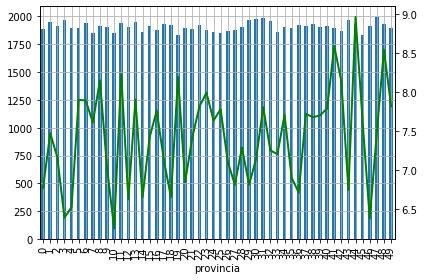

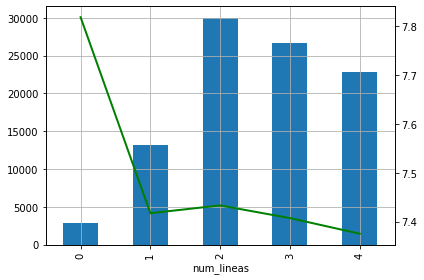

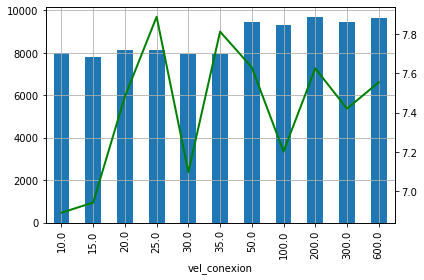

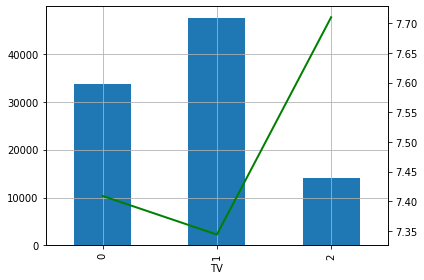

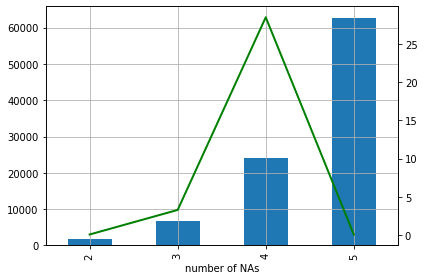

In [25]:
varsToPlot=data_diciembre.loc[:,pd.DataFrame(data_diciembre.columns, index=data_diciembre.columns).apply(lambda x: len(data_diciembre[x[0]].unique())<70 and len(data_diciembre[x[0]].unique())>2, axis=1)]   
varsToPlot=varsToPlot.loc[:,list(pd.DataFrame(varsToPlot.columns).apply(lambda x: x[0] not in '¿Abandona?', axis=1))] 

for i in varsToPlot.columns:
    proporciones_final (i, '¿Abandona?', data_diciembre) 

For continuous variables: var_name.describe() -> I select (min, 25%, median, 75%, max) as bins 

In [26]:
data_diciembre['new_TV_var']=data_diciembre.TV.apply(lambda x: 1 if x==2 else 0)
data_diciembre['new_vel_conexion']=data_diciembre.vel_conexion.apply(lambda x: 1 if x in [10,15,30,100] else 0)
data_diciembre['new_num_lineas']=data_diciembre.num_lineas.apply(lambda x: 0 if x==0 else 1)
data_diciembre['new_NA']=data_diciembre['number of NAs'].apply(lambda x: 1 if x==4 else 0) 

# data_diciembre.antiguedad.describe() -> I select (min, 25%, median, 75%, max) 
bins=[7.889702e+08, 9.858640e+08, 1.181438e+09, 1.378266e+09, 1.577759e+09]
labels=[0,1,2,3]
data_diciembre['NEW_antiguedad_bin']=pd.cut(data_diciembre['antiguedad'], bins=bins, labels=labels)

data_diciembre['new_binarized_antiguedad']=data_diciembre['NEW_antiguedad_bin'].apply(lambda x: 0 if x in [1,2] else 1) 

# data_diciembre.facturacion.describe() 
bins=[15.000439, 111.383822, 206.808431, 304.436599, 399.998433]
labels=[0,1,2,3]
data_diciembre['NEW_facturacion']=pd.cut(data_diciembre['facturacion'], bins=bins, labels=labels)

data_diciembre['categorical_facturacion']=data_diciembre.NEW_facturacion.apply(lambda x: 1 if x==1 else 0)  

# data_diciembre.mb_datos.describe() 
bins=[0, 6177.500000, 12466.000000, 18785.500000, 25000.000000]
labels=[0,1,2,3]
data_diciembre['NEW_mb_datos']=pd.cut(data_diciembre['mb_datos'], bins=bins, labels=labels)

data_diciembre['NEW_mb_datos']=data_diciembre.NEW_mb_datos.map({0:0, 1:1, 2:1, 3:2})  

corr = abs(data_diciembre.corr()) #since we have included a new var
corr[['¿Abandona?']].sort_values(by = '¿Abandona?',ascending = False).style.background_gradient() 

,¿Abandona?
¿Abandona?,1
new_NA,0.465407
number of NAs,0.223008
new_binarized_antiguedad,0.0109927
new_vel_conexion,0.0106265
provincia,0.00630453
num_llamad_ent,0.00612962
categorical_facturacion,0.00588859
new_TV_var,0.00459036
antiguedad,0.00314576


In [27]:
data_diciembre.isnull().sum() 

edad                        0
facturacion                 0
antiguedad                  0
provincia                   0
num_lineas                  0
num_llamad_ent              0
num_llamad_sal              0
mb_datos                    0
seg_llamad_ent              0
seg_llamad_sal              0
conexion                    0
vel_conexion                0
TV                          0
number of NAs               0
num_lineas_3                0
num_lineas_4                0
num_lineas_2                0
num_lineas_1                0
TV_tv-futbol                0
TV_tv-familiar              0
¿Abandona?                  0
new_TV_var                  0
new_vel_conexion            0
new_num_lineas              0
new_NA                      0
NEW_antiguedad_bin          2
new_binarized_antiguedad    2
NEW_facturacion             0
categorical_facturacion     0
NEW_mb_datos                1
dtype: int64

In [28]:
full=pd.read_csv('full_diciembre.csv')
others=full.loc[:,['num_dt','incidencia','financiacion','imp_financ','descuentos']] 

for col in ['incidencia','financiacion','descuentos']:
    others[str(col)]=others[str(col)].map({'SI':1}) 
 
data_diciembre=data_diciembre.fillna(0) # for the last 5 NA values
fill_others=others.fillna(0) 
all_vars=pd.concat([data_diciembre, fill_others.reindex(data_diciembre.index)], axis=1)

corr = abs(all_vars.corr()) #since we have included a new var
corr[['¿Abandona?']].sort_values(by = '¿Abandona?',ascending = False).style.background_gradient() 

,¿Abandona?
¿Abandona?,1
num_dt,0.504867
incidencia,0.500885
new_NA,0.465407
number of NAs,0.223008
descuentos,0.141447
financiacion,0.0745972
imp_financ,0.0676261
new_binarized_antiguedad,0.0109985
new_vel_conexion,0.0106265


# Select variables with correlation greater than 0.01

In [29]:
mask=(corr.loc['¿Abandona?',:].sort_values(ascending=False)>0.01)
all_vars=all_vars.loc[:,list(mask.index[mask])]  
all_vars.head(2)

,¿Abandona?,num_dt,incidencia,new_NA,number of NAs,descuentos,financiacion,imp_financ,new_binarized_antiguedad,new_vel_conexion
0,0,0.0,0.0,0,5,0.0,0.0,0.0,1.0,0
1,0,0.0,0.0,1,4,1.0,0.0,0.0,1.0,0


matriz de confusión
[[21681   415]
 [   29  1742]]
accuracy
0.9813969078644152
precision
0.8076031525266574
recall
0.9836250705815923
f1
0.8869653767820773
AUC
0.9824216953197608


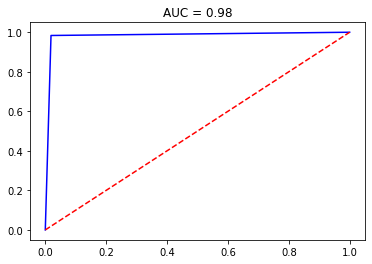

In [30]:
restOfVars=all_vars.loc[:, list(pd.DataFrame(all_vars.columns).apply(lambda x: x[0] not in ['TV_tv-total', 'num_lineas_5','¿Abandona?'], axis=1))]  
target=data_diciembre['¿Abandona?']
data_diciembre=pd.concat([restOfVars, target.reindex(target.index)], axis=1) 

X, y = data_diciembre.iloc[:,:-1], data_diciembre.iloc[:,-1] 
scaler = MinMaxScaler()    
X=scaler.fit_transform(X) 

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y)

classifier = LogisticRegression().fit(X_train, y_train)
y_pred     = classifier.predict(X_test) 

get_metrics(y_test, y_pred) 

# Random Forest with Grid Search

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, precision_score, recall_score, roc_curve

# scoring -> accuracy

matriz de confusión
[[21679   417]
 [   16  1755]]
accuracy
0.9818577952821888
precision
0.8080110497237569
recall
0.9909655561829475
f1
0.8901851382196296
AUC
0.9860466810603368


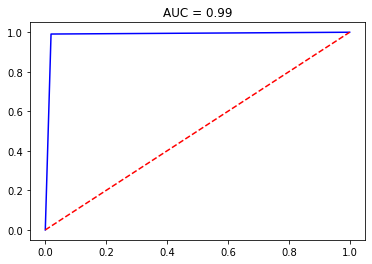

In [32]:
# Defino un modelo de random forest:
rand_forest_model = RandomForestClassifier(n_estimators=100, random_state=0)

grid_param = {
    'n_estimators': [100, 200, 500],
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True, False]
}

# Aplicar el grid sobre el modelo:
model_grid = GridSearchCV(estimator=rand_forest_model,
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)

classifier2 = model_grid.fit(X_train, y_train)
y_pred2     = classifier2.predict(X_test) 

get_metrics(y_test, y_pred2) 

# scoring -> 'f1'

matriz de confusión
[[21679   417]
 [   16  1755]]
accuracy
0.9818577952821888
precision
0.8080110497237569
recall
0.9909655561829475
f1
0.8901851382196296
AUC
0.9860466810603368


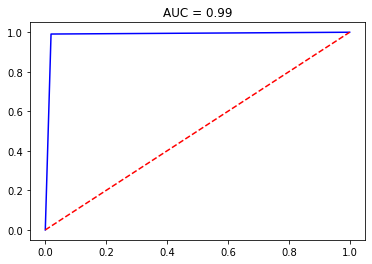

In [33]:
# Defino un modelo de random forest:
rand_forest_model = RandomForestClassifier(n_estimators=100, random_state=0)

grid_param = {
    'n_estimators': [100, 200, 500],
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True, False]
}

# Aplicar el grid sobre el modelo:
model_grid = GridSearchCV(estimator=rand_forest_model,
                     param_grid=grid_param,
                     scoring='f1',
                     cv=5,
                     n_jobs=-1)

classifier2 = model_grid.fit(X_train, y_train)
y_pred2     = classifier2.predict(X_test) 

get_metrics(y_test, y_pred2) 

# NEURAL NETWORK (from scratch with python)

In [86]:
X, y = data_diciembre.iloc[:,:-1], data_diciembre.iloc[:,-1]

scaler = MinMaxScaler()    
X=scaler.fit_transform(X) 

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y)
X_train, X_test, y_train, y_test = (np.array(X_train).T, np.array(X_test).T, 
                                    np.array(y_train).reshape(1,-1), 
                                    np.array(y_test).reshape(1,-1)) 

In [87]:
def initialization(layer_dims): #layer_dims has to be a list
    np.random.seed(1)  # to reproduce values
    parameters={}
    for l in range(1,len(layer_dims)):
        parameters['W'+str(l)]=np.random.randn(layer_dims[l],layer_dims[l-1])*0.01 
        parameters['b'+str(l)]=np.zeros((layer_dims[l],1))
    return parameters


# sigmoid as activation function in last layer, ReLU for remaining ones
def forward_propagation_AND_cost_computation(X, Y, parameters):
    forward_param={}
    A_prev=X
    layers=int(len(parameters)/2) 
    for l in range(1,layers): 
        forward_param['Z'+str(l)]=np.dot(parameters['W'+str(l)], A_prev)+parameters['b'+str(l)] 
        forward_param['A'+str(l)]=np.maximum(0, forward_param['Z'+str(l)]) #ReLU activation function
        A_prev=forward_param['A'+str(l)]

    #Last layer
    forward_param['Z'+str(layers)]=np.dot(parameters['W'+str(layers)], 
                                          A_prev)+parameters['b'+str(layers)]    
    forward_param['A'+str(layers)]=1/(1+np.exp(-(forward_param['Z'+str(layers)])))  

    Y=Y.reshape(1,-1) 
    
    AL=forward_param['A'+str(int(len(parameters)/2))].reshape(1,-1)
    #str(len(forward_param)/2)[0] returns '2.0'[0], which is only '2'
    m=Y.shape[1] 

    cost=-(1/m)*np.sum(Y*np.log(AL)+(1-Y)*np.log(1-AL))   
    
    return cost, forward_param, parameters



def backward_propagation(X, Y, parameters):
    loss, forward_param, weights = forward_propagation_AND_cost_computation(X, Y, parameters) #'forward_param' -> 'As' and 'Zs'
    grads={}
    last_layer = int(len(forward_param)/2) 
    m=Y.shape[1] 
    forward_param['A0']=X
    
    grads['dZ'+str(last_layer)]=forward_param['A'+str(last_layer)] - Y #here activation: sigmoid.
                                                                       #following layers: ReLU
    previous_dZ=grads['dZ'+str(last_layer)]
    for l in reversed(range(1,last_layer+1)):
        grads['dW'+str(l)] = ((1/m) * np.dot(previous_dZ, 
                                               forward_param['A'+str(l-1)].T))   
        grads['db'+str(l)] = (1/m) * np.sum(previous_dZ, axis=1, keepdims=True)
        
        if l>1:
            grads['dZ'+str(l-1)] = (np.dot(weights['W'+str(l)].T, previous_dZ) * 
                                    np.array(forward_param['Z'+str(l-1)]>=0, dtype=float))    
            
            previous_dZ = grads['dZ'+str(l-1)]
            
    return grads

In [93]:
# standard update of parameters
def gradient_update(parameters, grads, learning_rate=1):
    for l in range(1, int(len(parameters)/2+1)):    
        parameters['W'+str(l)] = parameters['W'+str(l)] - learning_rate * grads['dW'+str(l)]
        parameters['b'+str(l)] = parameters['b'+str(l)] - learning_rate * grads['db'+str(l)] 
    return parameters

I am going to implement the parameters update with Adam. 
This is the general update rule is, for $l = 1, ..., L$: 

$$\begin{cases}
v_{W^{[l]}} = \beta_1 v_{W^{[l]}} + (1 - \beta_1) \frac{\partial J }{ \partial W^{[l]} } \\
v^{corrected}_{W^{[l]}} = \frac{v_{W^{[l]}}}{1 - (\beta_1)^t} \\
s_{W^{[l]}} = \beta_2 s_{W^{[l]}} + (1 - \beta_2) (\frac{\partial J }{\partial W^{[l]} })^2 \\
s^{corrected}_{W^{[l]}} = \frac{s_{W^{[l]}}}{1 - (\beta_2)^t} \\
W^{[l]} = W^{[l]} - \alpha \frac{v^{corrected}_{W^{[l]}}}{\sqrt{s^{corrected}_{W^{[l]}}}+\varepsilon}
\end{cases}$$ 

In [89]:
def initialize_adam(parameters) :
    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    s = {}

    for l in range(L):
        v["dW" + str(l+1)] = np.zeros(parameters['W'+str(l+1)].shape)
        v["db" + str(l+1)] = np.zeros(parameters['b'+str(l+1)].shape)
        s["dW" + str(l+1)] = np.zeros(parameters['W'+str(l+1)].shape)
        s["db" + str(l+1)] = np.zeros(parameters['b'+str(l+1)].shape)
    return v, s




def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate = 0.01,
                                beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):
    L = len(parameters) // 2                 # number of layers in the neural networks
    v_corrected = {}                         # Initializing first moment estimate, python dictionary
    s_corrected = {}                         # Initializing second moment estimate, python dictionary
    
    # Perform Adam update on all parameters
    for l in range(L):
        v["dW" + str(l+1)] = beta1*v['dW'+str(l+1)] + (1-beta1)*grads['dW'+str(l+1)]
        v["db" + str(l+1)] = beta1*v['db'+str(l+1)] + (1-beta1)*grads['db'+str(l+1)]

        v_corrected["dW" + str(l+1)] = v["dW" + str(l+1)]/(1-beta1**t)
        v_corrected["db" + str(l+1)] = v["db" + str(l+1)]/(1-beta1**t)

        s["dW" + str(l+1)] = beta2*s['dW'+str(l+1)] + (1-beta2)*(grads['dW'+str(l+1)]**2)
        s["db" + str(l+1)] = beta2*s['db'+str(l+1)] + (1-beta2)*(grads['db'+str(l+1)]**2)

        s_corrected["dW" + str(l+1)] = s["dW" + str(l+1)]/(1-beta2**t)
        s_corrected["db" + str(l+1)] = s["db" + str(l+1)]/(1-beta2**t)

        parameters["W" + str(l+1)] = parameters['W'+str(l+1)] - (learning_rate*(v_corrected['dW'+str(l+1)]/(np.sqrt(s_corrected['dW'+str(l+1)])+epsilon)))  
        parameters["b" + str(l+1)] = parameters['b'+str(l+1)] - (learning_rate*(v_corrected['db'+str(l+1)]/(np.sqrt(s_corrected['db'+str(l+1)])+epsilon)))

    return parameters

In [90]:
def predict(X, Y, parameters):
    forward_param={}
    A_prev=X
    layers=int(len(parameters)/2) 
    for l in range(1,layers): 
        forward_param['Z'+str(l)]=np.dot(parameters['W'+str(l)], A_prev)+parameters['b'+str(l)] 
        forward_param['A'+str(l)]=np.maximum(0, forward_param['Z'+str(l)]) #ReLU activation function
        A_prev=forward_param['A'+str(l)]

    #Last layer
    forward_param['Z'+str(layers)]=np.dot(parameters['W'+str(layers)], 
                                          A_prev)+parameters['b'+str(layers)]    
    forward_param['A'+str(layers)]=1/(1+np.exp(-(forward_param['Z'+str(layers)])))  

    Y=Y.reshape(1,-1) 
    
    AL=forward_param['A'+str(int(len(parameters)/2))].reshape(1,-1)

    return np.array(AL>0.1, dtype=float) 

In [97]:
def L_model(layer_dims, X, Y, number_of_iterations, update_method='adam'):
    layer_dims=layer_dims
    previous_parameters = initialization(layer_dims)
    values=[]
    t=0
    
    for i in range(number_of_iterations):
        loss, forward_param, previous_parameters = forward_propagation_AND_cost_computation(X, Y, previous_parameters)
        
        values.append(loss)
        
        grads = backward_propagation(X, Y, previous_parameters)
        if i%20==0:
            print('iteration {}, cost: {}'.format(i,loss)) 
#             print(forward_param['A'+str(int(len(layer_dims)-1))]) 

#         previous_parameters = gradient_update(previous_parameters, grads)
        if update_method=='adam':
            v,s = initialize_adam(previous_parameters)
            t = t + 1 # Adam counter
            previous_parameters=update_parameters_with_adam(previous_parameters, grads, v, s, t)
        else:
            previous_parameters = gradient_update(previous_parameters, grads) 
         
    y=Y
    y_hat=forward_param['A'+str(int(len(previous_parameters)/2))] 
    
    accuracy=np.array(y==np.array(y_hat>0.1, dtype=float), dtype=float)

    print('\n\n accuracy train: {}'.format(round(np.sum(accuracy)/len(accuracy[0]),8)))   
    
    plt.plot(np.squeeze(values))  
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning Process")
    plt.show() 
    return previous_parameters

-Update method: Adam \
-No hyperparameter gridsearch

iteration 0, cost: 0.6931462753487738
iteration 20, cost: 0.550255746632483
iteration 40, cost: 0.23980183147927422
iteration 60, cost: 0.11901008498890535
iteration 80, cost: 0.06523130372472942


 accuracy train: 0.98385475


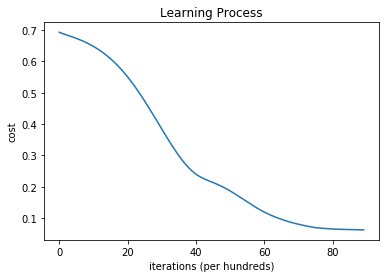

In [98]:
fitted_parameters_adam = L_model(layer_dims=[X_train.shape[0],20,7,1], X=X_train, Y=y_train, 
                            number_of_iterations=90)  

matriz de confusión
[[21675   421]
 [   12  1759]]
accuracy
0.9818577952821888
precision
0.8068807339449541
recall
0.9932241671372106
f1
0.8904074917742344
AUC
0.9870854724172657


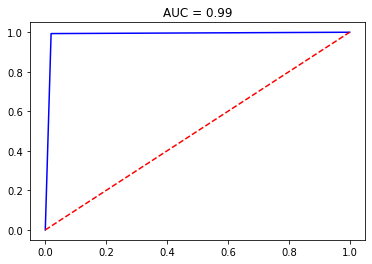

In [99]:
y_pred=predict(X_test, y_test, fitted_parameters_adam)
get_metrics(y_test[0], y_pred[0]) 

In [1]:
32-9

23